In [3]:
!git clone https://github.com/Arminkhayati/Retinopathy_Dataset


Cloning into 'Retinopathy_Dataset'...
remote: Enumerating objects: 88718, done.
remote: Total 88718 (delta 0), reused 0 (delta 0), pack-reused 88718
Receiving objects: 100% (88718/88718), 1.63 GiB | 35.02 MiB/s, done.
Resolving deltas: 100% (1/1), done.
Checking out files: 100% (88704/88704), done.


In [1]:
import numpy as np
import pandas as pd
import time
import keras
import cv2
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, Activation, Concatenate, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.applications.nasnet import NASNetMobile, preprocess_input

from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, TensorBoard, LambdaCallback

import imgaug as ia
from imgaug import augmenters as iaa


class DataGenerator(keras.utils.Sequence):
	'Generates data for Keras'
	def __init__(self, images_paths, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
		self.labels       = labels              # array of labels
		self.images_paths = images_paths        # array of image paths
		self.dim          = image_dimensions    # image dimensions
		self.batch_size   = batch_size          # batch size
		self.shuffle      = shuffle             # shuffle bool
		self.augment      = augment             # augment data bool
		self.on_epoch_end()

	def __len__(self):
		'Denotes the number of batches per epoch'
		return int(np.floor(len(self.images_paths) / self.batch_size))

	def on_epoch_end(self):
		'Updates indexes after each epoch'
		self.indexes = np.arange(len(self.images_paths))
		if self.shuffle:
			np.random.shuffle(self.indexes)

	def __getitem__(self, index):
		'Generate one batch of data'
		# selects indices of data for next batch
		indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

		# select data and load images
		labels = np.array([self.labels[k] for k in indexes])
		images = [cv2.imread(self.images_paths[k]) for k in indexes]
        
		# preprocess and augment data
		if self.augment == True:
		    images = self.augmentor(images)
		preprocess_fun = lambda img : img / 255.0
		images = np.array([preprocess_fun(img) for img in images], dtype='float32')
		return images, labels
	
	def myget(self, index):
		'Generate one batch of data'
		# selects indices of data for next batch
		indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

		# select data and load images
		labels = np.array([self.labels[k] for k in indexes])
		images = [cv2.imread(self.images_paths[k]) for k in indexes]

		# preprocess and augment data
		if self.augment == True:
		    images = self.augmentor(images)
		preprocess_fun = lambda img : img / 255.0
		images = np.array([preprocess_fun(img) for img in images], dtype='float32')
		return images, labels
	
	def augmentor(self, images):
		'Apply data augmentation'
		sometimes = lambda aug: iaa.Sometimes(0.5, aug)
		seq = iaa.Sequential(
				[
				# apply the following augmenters to most images
				iaa.Fliplr(0.5),  # horizontally flip 50% of all images
				iaa.Flipud(0.2),  # vertically flip 20% of all images
        # iaa.Alpha((0.0, 1.0), iaa.AllChannelsHistogramEqualization()),
				# execute 0 to 5 of the following (less important) augmenters per image
				# don't execute all of them, as that would often be way too strong
				# iaa.SomeOf((0, 2),
				#            [sometimes(iaa.Superpixels(p_replace=(0, 1.0),
				# 		                                     n_segments=(20, 200))),
				# 	           # convert images into their superpixel representation
				# 	           iaa.Add((-10, 20), per_channel=0.5)
				# 	           # change brightness of images (by -10 to 10 of original value)
				#            ],
				#            random_order=True
				#            )
				],
				random_order=True
		)
		return seq.augment_images(images)

In [6]:
import os
import pandas as pd

base_image_dir = os.path.join('/home/deeplearning/Projects/Datasets/eyePACS/512x512-optimized')
lower_bound_rank = 3
retina_df = pd.read_csv(os.path.join(base_image_dir, 'train.csv'))
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[2])
retina_df['path'] = retina_df['label'].map(lambda x: os.path.join(base_image_dir, 'train/{}'.format(x)))
print('Original Shape:' ,retina_df.shape)
retina_df = retina_df.drop(retina_df[(retina_df['label'] == 0) & (retina_df['rank'] < lower_bound_rank)].index)
retina_df['path'] = retina_df['path'] + '/' + retina_df['image']
retina_df['exists'] = retina_df['path'].map(os.path.exists)
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left.jpg' else 0)
from keras.utils.np_utils import to_categorical
retina_df['level_cat'] = retina_df['label'].map(lambda x: to_categorical(x, 1+retina_df['label'].max()))
retina_df.dropna(inplace = True)
retina_df = retina_df[retina_df['exists']]
print('Train Dataframe size = ' , len(retina_df))
retina_df.sample(5)


34188 images found of 34188 total
Train Dataframe size =  34188


,image,label,rank,PatientId,path,exists,eye,level_cat
25995,040_0_4838_right.jpg,0,40,4838,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
33033,076_0_17243_right.jpg,0,76,17243,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
2558,101_0_29535_right.jpg,0,101,29535,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
8960,054_2_15117_left.jpg,2,54,15117,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,1,"[0.0, 0.0, 1.0, 0.0, 0.0]"
25666,078_0_6189_left.jpg,0,78,6189,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [8]:
retina_df_test = pd.read_csv(os.path.join(base_image_dir, 'test.csv'))
retina_df_test['PatientId'] = retina_df_test['image'].map(lambda x: x.split('_')[2])
retina_df_test['path'] = retina_df_test['label'].map(lambda x: os.path.join(base_image_dir, 'test/{}'.format(x)))
print('Original Shape:' ,retina_df_test.shape)
retina_df_test = retina_df_test.drop(retina_df_test[(retina_df_test['label'] == 0) & (retina_df_test['rank'] < lower_bound_rank)].index)
retina_df_test['path'] = retina_df_test['path'] + '/' + retina_df_test['image']
retina_df_test['exists'] = retina_df_test['path'].map(os.path.exists)
print(retina_df_test['exists'].sum(), 'images found of', retina_df_test.shape[0], 'total')
retina_df_test['eye'] = retina_df_test['image'].map(lambda x: 1 if x.split('_')[-1]=='left.jpg' else 0)
from keras.utils.np_utils import to_categorical
retina_df_test['level_cat'] = retina_df_test['label'].map(lambda x: to_categorical(x, 1+retina_df_test['label'].max()))
retina_df_test.dropna(inplace = True)
retina_df_test = retina_df_test[retina_df_test['exists']]
print('Test Dataframe size = ' , len(retina_df_test))
retina_df_test.sample(5)

Original Shape: (52562, 5)
52155 images found of 52155 total
Test Dataframe size =  52155


,image,label,rank,PatientId,path,exists,eye,level_cat
1217,074_0_42605_left.jpg,0,74,42605,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
9462,079_0_35565_right.jpg,0,79,35565,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
8985,103_2_14803_right.jpg,2,103,14803,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[0.0, 0.0, 1.0, 0.0, 0.0]"
45223,057_0_7042_right.jpg,0,57,7042,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
1481,041_0_34895_right.jpg,0,41,34895,/home/deeplearning/Projects/Datasets/eyePACS/5...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"


In [9]:
from sklearn.model_selection import train_test_split

rr_df = retina_df[['PatientId', 'label']].drop_duplicates()
train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2020,
                                   stratify = rr_df['label'])
raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]
valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]
print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train_df = raw_train_df
validation_df = valid_df
test_df = retina_df_test
validation_df = validation_df[~validation_df.PatientId.isin(train_df.PatientId)]
print('Test Size = ',test_df.shape[0],' Validation Size = ',validation_df.shape[0] , 'Train Data = ',train_df.shape[0])


train 26442 validation 9350
Test Size =  52155  Validation Size =  7746 Train Data =  26442


In [10]:
batch_size = 8


In [13]:
train_data = DataGenerator(train_df['path'].values, train_df['level_cat'].values, batch_size=batch_size, augment=True, shuffle=True)
validation_data = DataGenerator(validation_df['path'].values, validation_df['level_cat'].values, batch_size=batch_size, augment=False, shuffle=False)
# test_data = DataGenerator(test_df['path'].values, test_df['level_cat'].values, batch_size=batch_size, augment=False, shuffle=False)


(512, 512, 3)

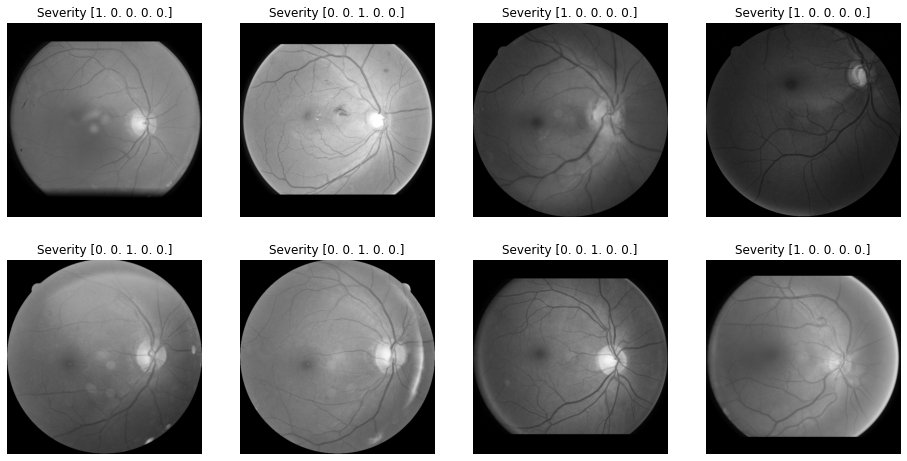

In [12]:
import cv2

t_x, t_y = train_data.myget(0)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
      c_x = cv2.cvtColor(c_x, cv2.COLOR_BGR2RGB)
      # c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
      c_ax.imshow(np.clip(c_x * 255, 0, 255).astype(np.uint8))
      c_ax.set_title('Severity {}'.format(c_y))
      c_ax.axis('off')

t_x.shape[1:]

In [14]:
import numpy as np
adjancy_matrix = [[0.850, 0.150, 0.0, 0.0, 0.0],
                  [0.150, 0.700, 0.150, 0.0, 0.0],
                  [0.0, 0.150, 0.700, 0.150, 0.0],
                  [0.0, 0.0, 0.150, 0.700, 0.150],
                  [0.0, 0.0, 0.0, 0.150, 0.850]]
node_feature = [[1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0],
                [0.0, 0.0, 0.0, 1.0, 0.0],
                [0.0, 0.0, 0.0, 0.0, 1.0]]

A = np.array(adjancy_matrix, dtype='float32')
X = np.array(node_feature, dtype='float32')
# X = np.expand_dims(X,axis=1)

print('Shape of A: ', A.shape)
print('\nShape of X: ', X.shape)
print('\nAdjacency Matrix (A):\n', A)
print('\nNode Features Matrix (X):\n', X)

Shape of A:  (5, 5)

Shape of X:  (5, 5)

Adjacency Matrix (A):
 [[0.85 0.15 0.   0.   0.  ]
 [0.15 0.7  0.15 0.   0.  ]
 [0.   0.15 0.7  0.15 0.  ]
 [0.   0.   0.15 0.7  0.15]
 [0.   0.   0.   0.15 0.85]]

Node Features Matrix (X):
 [[1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1.]]


In [15]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from keras.layers import GlobalAveragePooling2D, Dense, Softmax, Input, BatchNormalization, multiply, Activation, Add, Lambda
from keras.models import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as effnet
from tensorflow.keras import activations
from spektral.layers import GraphConv
# from spektral.layers import GCNConv
from keras.optimizers import Adam

input_shape = (512, 512, 3)
inputs = Input(shape=(512, 512, 3))

#Base Model
# base_pretrained_model = Xception(input_shape = input_shape , include_top = False, weights = 'imagenet')
base_pretrained_model = effnet(input_shape = input_shape , include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = True
binp = base_pretrained_model.input
# base_pretrained_model = base_pretrained_model(inputs, training=True)
gap = GlobalAveragePooling2D()(base_pretrained_model.output)
# gap = GlobalAveragePooling2D()(base_pretrained_model)
fc = Dense(5)(gap)

# Class-Dependency Model

gcn_1 = GraphConv(5, 'relu')([X, A])
gcn = GraphConv(gap.shape[-1])([gcn_1, A])
# gcn_1 = GCNConv(5, 'relu')([X, A])
# gcn = GCNConv(gap.shape[-1])([gcn_1, A])

# Fusing

def matrix_mul(x):
  a, b = x
  b = tf.transpose(b)
  return tf.matmul(a, b)

matmul = Lambda(matrix_mul)((gap, gcn))
matmul_relu = Activation(activations.sigmoid)(matmul)
fc_matmul_relu_mul = multiply([fc, matmul_relu])
model = Add()([fc, fc_matmul_relu_mul])
model = Softmax()(model)
model = Model(binp, model)
model.compile(optimizer = Adam(), loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 255, 255, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 255, 255, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 255, 255, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('retina')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
callbacks_list = [checkpoint, reduceLROnPlat]


history = model.fit(train_data, 
                           steps_per_epoch = train_df.shape[0]//batch_size,
                           validation_data = validation_data, 
                           validation_steps = validation_df.shape[0]//batch_size,
                              epochs = 60, 
                              callbacks = callbacks_list,
                            #  workers = 0, # tf-generators are not thread-safe
                            #  use_multiprocessing=False, 
                            #  max_queue_size = 0
                            )
model.load_weights(weight_path)
model.save('full_retina_model.h5')

Epoch 1/60
3305/3305 [==============================] - ETA: 0s - loss: 0.7634 - categorical_accuracy: 0.7467
Epoch 00001: val_loss improved from inf to 0.58649, saving model to retina_weights.best.hdf5
3305/3305 [==============================] - 1317s 399ms/step - loss: 0.7634 - categorical_accuracy: 0.7467 - val_loss: 0.5865 - val_categorical_accuracy: 0.8200 - lr: 0.0010
Epoch 2/60
3305/3305 [==============================] - ETA: 0s - loss: 0.6862 - categorical_accuracy: 0.7675
Epoch 00002: val_loss improved from 0.58649 to 0.54046, saving model to retina_weights.best.hdf5
3305/3305 [==============================] - 1375s 416ms/step - loss: 0.6862 - categorical_accuracy: 0.7675 - val_loss: 0.5405 - val_categorical_accuracy: 0.8360 - lr: 0.0010
Epoch 3/60
3305/3305 [==============================] - ETA: 0s - loss: 0.6466 - categorical_accuracy: 0.7812
Epoch 00003: val_loss improved from 0.54046 to 0.53208, saving model to retina_weights.best.hdf5
3305/3305 [======================

Epoch 24/60
3305/3305 [==============================] - ETA: 0s - loss: 0.3250 - categorical_accuracy: 0.8893
Epoch 00024: val_loss did not improve from 0.43479

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
3305/3305 [==============================] - 1352s 409ms/step - loss: 0.3250 - categorical_accuracy: 0.8893 - val_loss: 0.5862 - val_categorical_accuracy: 0.8197 - lr: 8.0000e-04
Epoch 25/60
3305/3305 [==============================] - ETA: 0s - loss: 0.2972 - categorical_accuracy: 0.8972
Epoch 00025: val_loss did not improve from 0.43479
3305/3305 [==============================] - 1356s 410ms/step - loss: 0.2972 - categorical_accuracy: 0.8972 - val_loss: 0.5062 - val_categorical_accuracy: 0.8534 - lr: 6.4000e-04
Epoch 26/60
3305/3305 [==============================] - ETA: 0s - loss: 0.2745 - categorical_accuracy: 0.9072
Epoch 00026: val_loss did not improve from 0.43479
3305/3305 [==============================] - 1352s 409ms/step - loss: 0.274

In [17]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

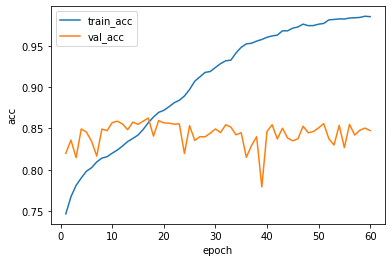

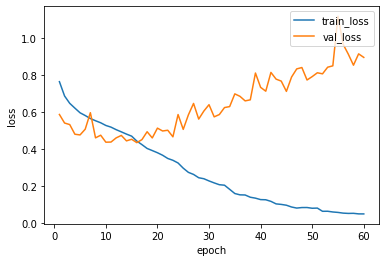

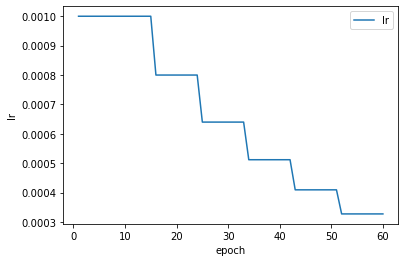

In [19]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10

def plotmodel(history,name):
    
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    lrs = history.history['lr']
    epochs = range(1, len(acc) + 1) 
    
    plt.figure(1)                  
    plt.plot(epochs,acc)#mooth_curve(acc))
    plt.plot(epochs,val_acc)#smooth_curve(val_acc))
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['train_acc', 'val_acc'], loc='upper left')
    plt.savefig('acc_'+name+'.png')
    
    plt.figure(2)
    plt.plot(epochs, loss)#smooth_curve(loss))
    plt.plot(epochs,val_loss)#smooth_curve(val_loss))
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'val_loss'], loc='upper right')
    plt.savefig('loss_'+name+'.png')
    
    plt.figure(3)
    plt.plot(epochs,lrs)
    plt.ylabel('lr')
    plt.xlabel('epoch')
    plt.legend(['lr'], loc='upper right')
    plt.savefig('lr_'+name+'.png')

plotmodel(history,'Xception')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('./full_retina_model.h5')

In [20]:
test_data = DataGenerator(retina_df_test['path'].values, retina_df_test['level_cat'].values, batch_size=batch_size, augment=False, shuffle=False)
pred= model.predict(test_data, steps=retina_df_test.shape[0] // batch_size, verbose=1)


6519/6519 [==============================] - 429s 66ms/step


In [36]:
predicted_class_indices=np.argmax(pred,axis=1)
labels = retina_df_test['label']
labels = labels[0:len(predicted_class_indices)]
labels2= dict((v,k) for k,v in labels.items())
predictions=[labels2[k] for k in predicted_class_indices]

In [37]:
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix

print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(labels, predicted_class_indices)))
print(classification_report(labels, predicted_class_indices))

Accuracy on Test Data: 0.82%
              precision    recall  f1-score   support

           0       0.87      0.97      0.92     38528
           1       0.42      0.18      0.26      3736
           2       0.65      0.57      0.60      7655
           3       0.54      0.22      0.32      1163
           4       0.72      0.25      0.37      1070

    accuracy                           0.82     52152
   macro avg       0.64      0.44      0.49     52152
weighted avg       0.80      0.82      0.80     52152



<AxesSubplot:>

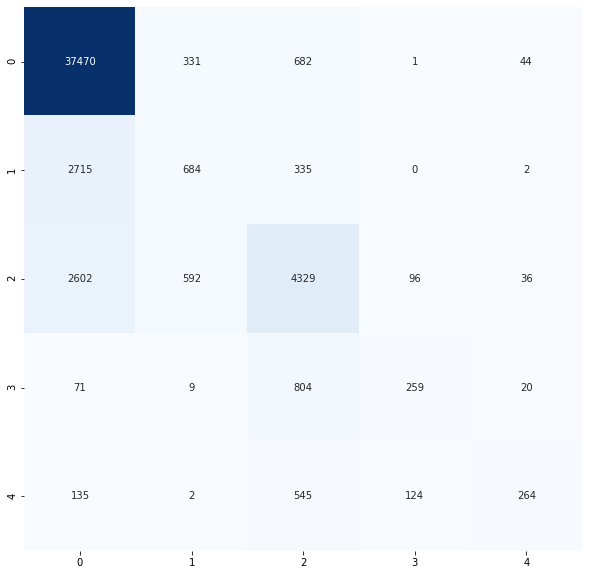

In [38]:
sns.heatmap(confusion_matrix(labels, predicted_class_indices), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues)

Text(0, 0.5, 'True Positive Rate')

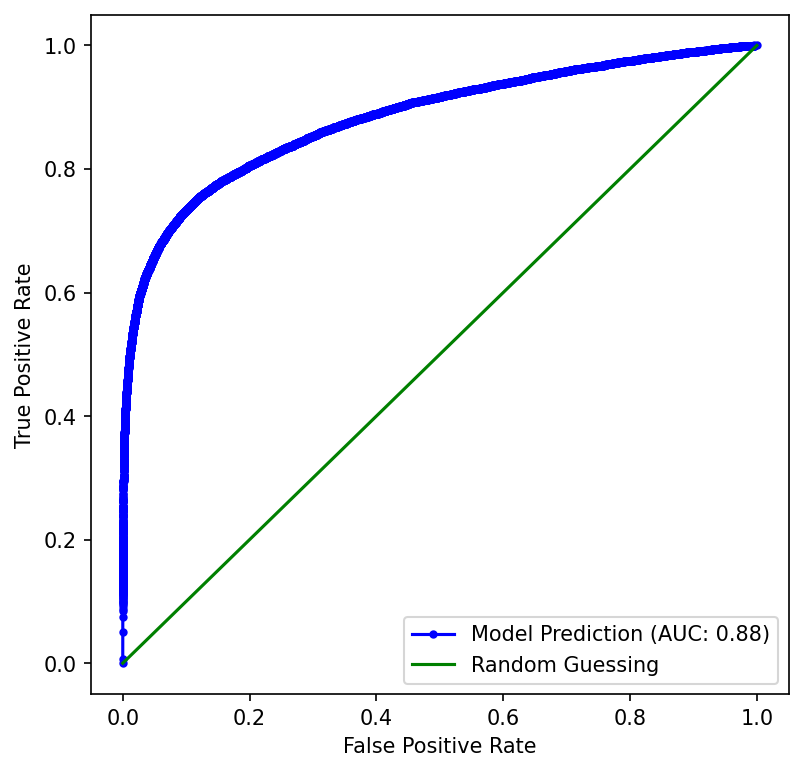

In [39]:
from sklearn.metrics import roc_curve, roc_auc_score
sick_vec = labels>0
sick_score = np.sum(pred[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')

In [40]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
n_classes=5
# For each class
precision = dict()
recall = dict()
average_precision = dict()
level_cat = retina_df_test[:len(labels)].level_cat
level_cat = np.array([l.flatten() for l in level_cat])
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(level_cat[:, i],
                                                        pred[:, i])
    average_precision[i] = average_precision_score(level_cat[:, i], pred[:, i])

In [41]:
precision["micro"], recall["micro"], _ = precision_recall_curve(level_cat.ravel(),
    pred.ravel())
average_precision["micro"] = average_precision_score(level_cat, pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.88


Text(0.5, 1.0, 'Average precision score, micro-averaged over all classes: AP=0.88')

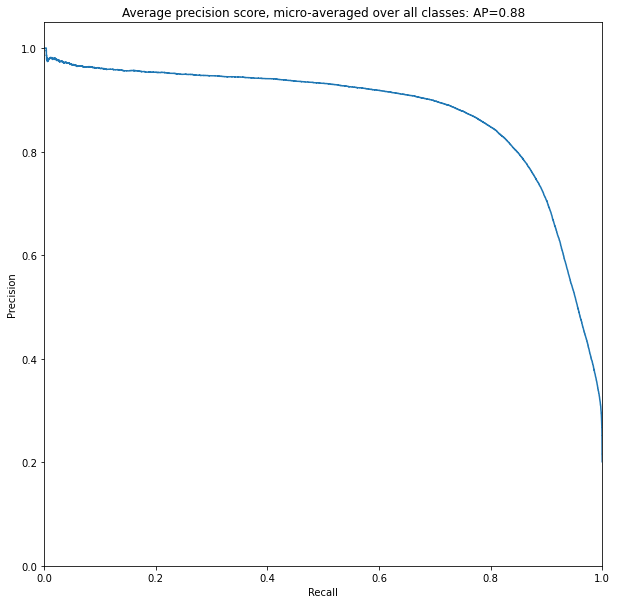

In [42]:
plt.figure()
plt.step(recall['micro'], precision['micro'], where='post')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))

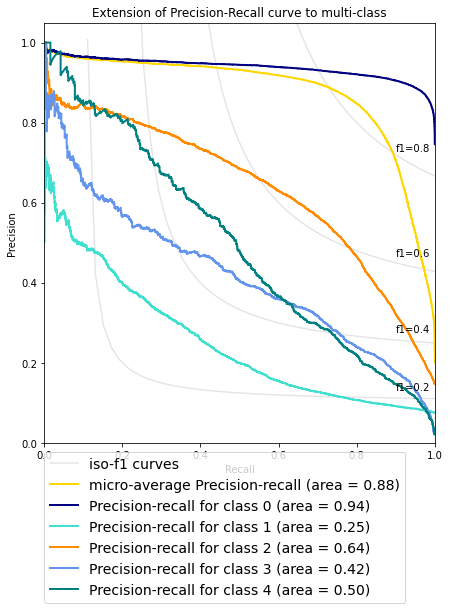

In [45]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

In [30]:
from sklearn.metrics import auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(level_cat[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(level_cat.ravel(), pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

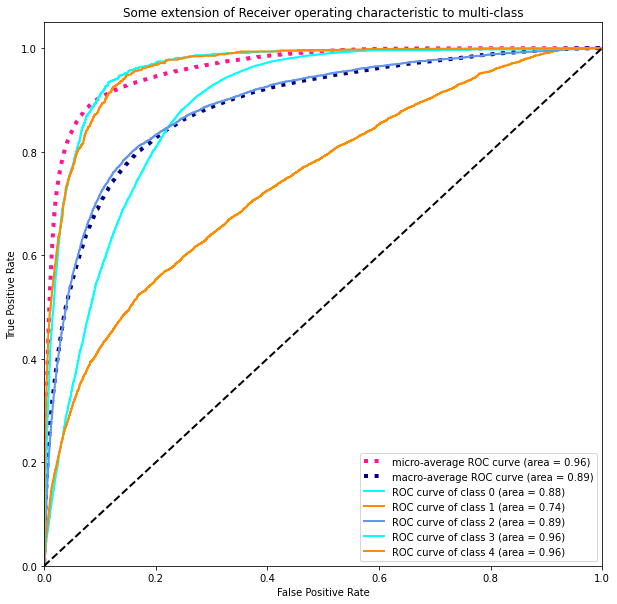

In [35]:

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
lw = 2
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()
